In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

# Check tensorflow version
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.15.0


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_19 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_10 (Flatten)        (None, 6272)            

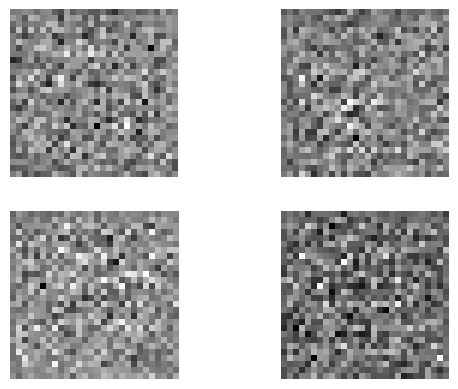

1/1 [==============================] - 0s 16ms/step
Epoch 100, D Loss: 0.00018136400882440284, G Loss: 0.0020121452398598194
1/1 [==============================] - 0s 20ms/step


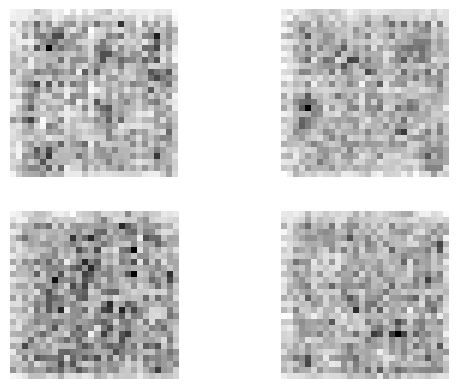

1/1 [==============================] - 0s 16ms/step
Epoch 200, D Loss: 3.034743913499227e-05, G Loss: 0.0004454815061762929
1/1 [==============================] - 0s 17ms/step


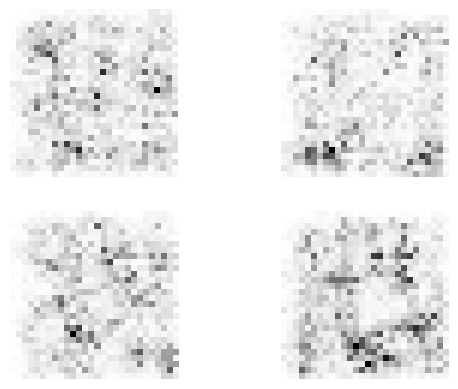

1/1 [==============================] - 0s 16ms/step
Epoch 300, D Loss: 0.00022898044153407682, G Loss: 0.00015198525215964764
1/1 [==============================] - 0s 24ms/step


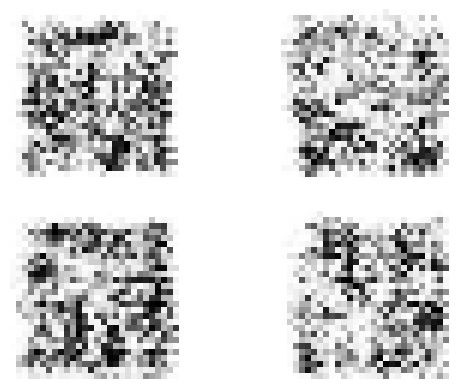

1/1 [==============================] - 0s 20ms/step
Epoch 400, D Loss: 0.7306906282901764, G Loss: 0.6085326075553894
1/1 [==============================] - 0s 26ms/step


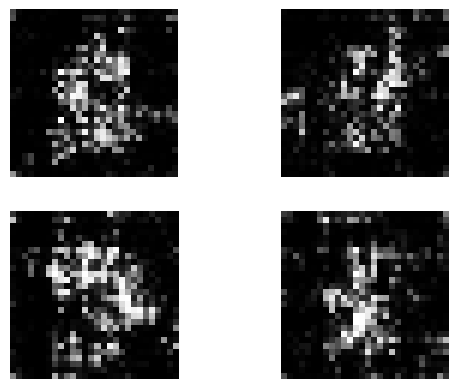

1/1 [==============================] - 0s 22ms/step
Epoch 500, D Loss: 0.7051199674606323, G Loss: 0.7298823595046997
1/1 [==============================] - 0s 21ms/step


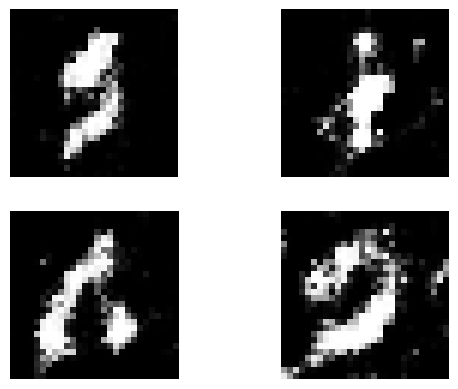

1/1 [==============================] - 0s 19ms/step
Epoch 600, D Loss: 0.6994213163852692, G Loss: 0.7299647331237793
1/1 [==============================] - 0s 20ms/step


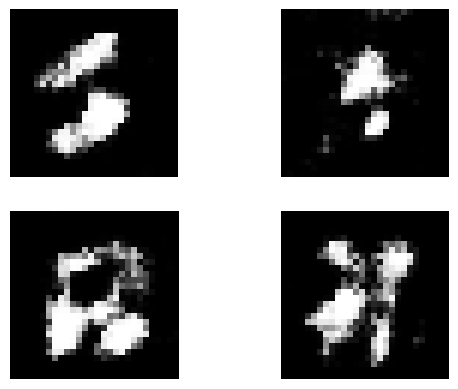

1/1 [==============================] - 0s 21ms/step
Epoch 700, D Loss: 0.6975348591804504, G Loss: 0.7562885284423828
1/1 [==============================] - 0s 24ms/step


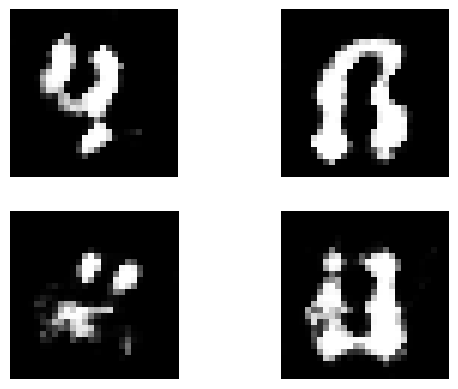

1/1 [==============================] - 0s 16ms/step
Epoch 800, D Loss: 0.6954502761363983, G Loss: 0.7369143962860107
1/1 [==============================] - 0s 22ms/step


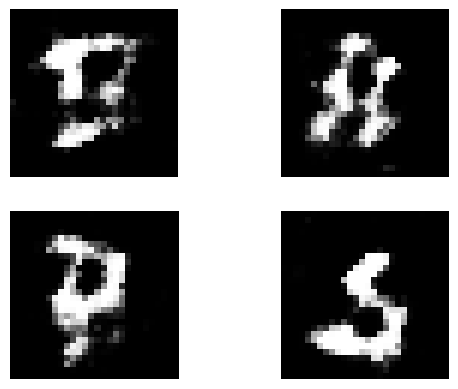

1/1 [==============================] - 0s 28ms/step
Epoch 900, D Loss: 0.7223747968673706, G Loss: 0.7271877527236938
1/1 [==============================] - 0s 32ms/step


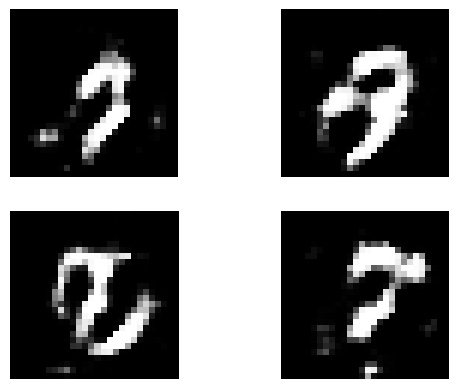

1/1 [==============================] - 0s 276ms/step


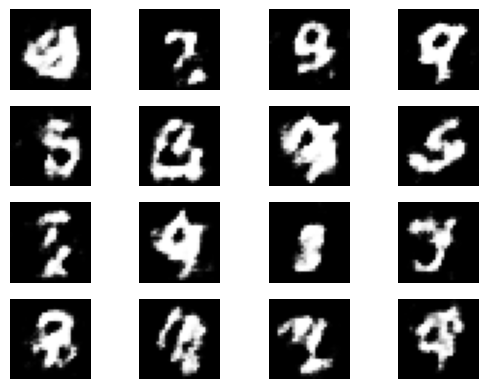

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 127.5 - 1.0  # Normalize images to the range [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

# GAN Parameters
latent_dim = 500
img_shape = (28, 28, 1)

# Generator Model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(4 * 4 * 256, input_dim=latent_dim))
    model.add(layers.Reshape((4, 4, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.Conv2DTranspose(3, (4, 4), padding='same', activation='tanh'))
    model.add(layers.Conv2DTranspose(1, (4, 4), padding='same', activation='tanh'))
    model.add(layers.Cropping2D(((2,2),(2,2))))
    return model


# Discriminator Model
def build_discriminator(img_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Combined Model (GAN)

# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()

# Build and compile the generator
generator = build_generator(latent_dim)
generator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
generator.summary()


def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Build and compile the GAN model
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))


def samples():
  generated_images = generator.predict(np.random.normal(0, 1, (4, latent_dim)))

  fig, axs = plt.subplots(2, 2)
  count = 0
  for i in range(2):
      for j in range(2):
          axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
          axs[i, j].axis('off')
          count += 1
  plt.show()

  
# Training loop
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    labels_gan = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, labels_gan)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        samples()

# Generate some images with the trained generator
generated_images = generator.predict(np.random.normal(0, 1, (16, latent_dim)))

# Display the generated images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4)
count = 0
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        count += 1
plt.show()


1/1 [==============================] - 0s 50ms/step
Epoch 0, D Loss: 0.695000559091568, G Loss: 0.7074874639511108
1/1 [==============================] - 0s 102ms/step


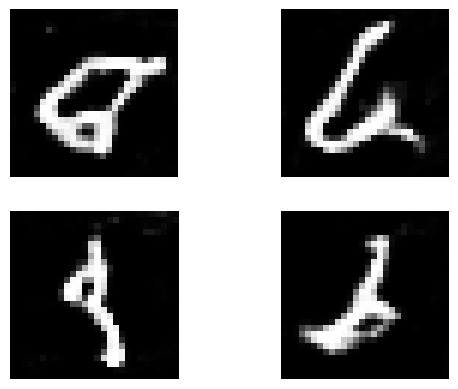

1/1 [==============================] - 0s 26ms/step
Epoch 100, D Loss: 0.6905305981636047, G Loss: 0.6976747512817383
1/1 [==============================] - 0s 35ms/step


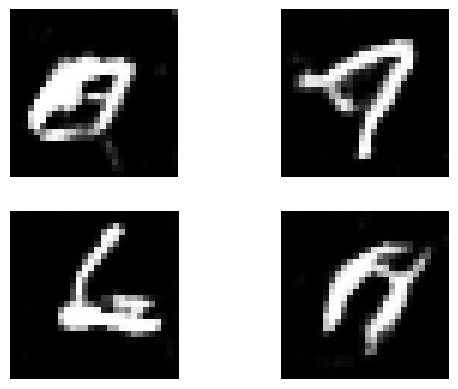

1/1 [==============================] - 0s 25ms/step
Epoch 200, D Loss: 0.6912955939769745, G Loss: 0.7115951180458069
1/1 [==============================] - 0s 30ms/step


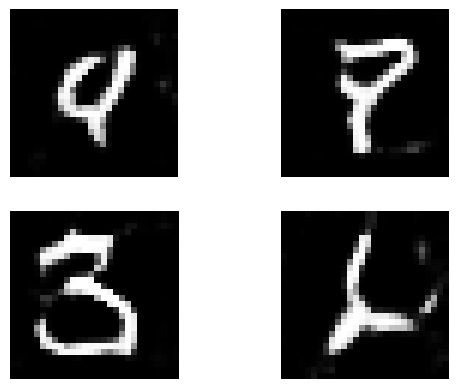

1/1 [==============================] - 0s 17ms/step
Epoch 300, D Loss: 0.6932058930397034, G Loss: 0.6676414608955383
1/1 [==============================] - 0s 18ms/step


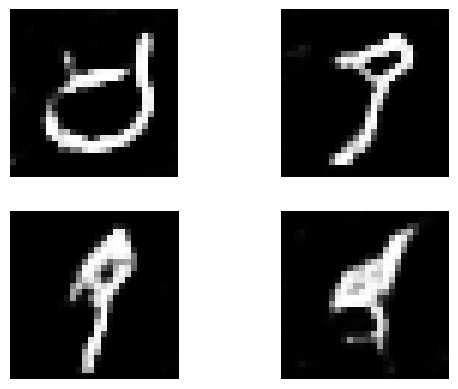

1/1 [==============================] - 0s 17ms/step
Epoch 400, D Loss: 0.6794704794883728, G Loss: 0.6822060942649841
1/1 [==============================] - 0s 21ms/step


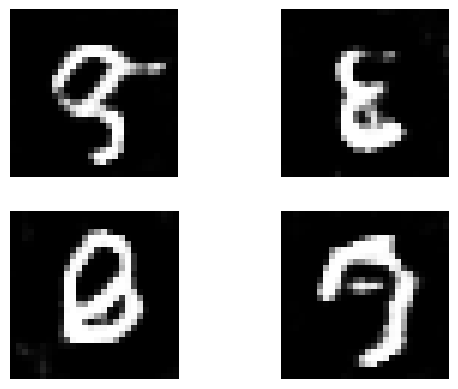

1/1 [==============================] - 0s 16ms/step
Epoch 500, D Loss: 0.7124888598918915, G Loss: 0.7061896324157715
1/1 [==============================] - 0s 23ms/step


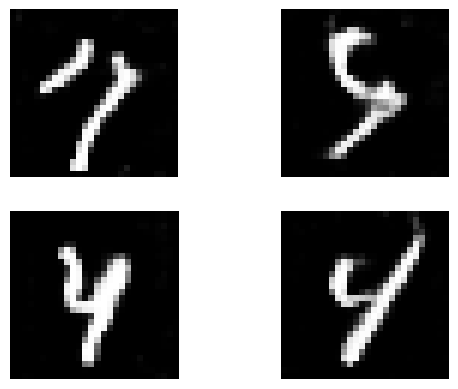

1/1 [==============================] - 0s 19ms/step
Epoch 600, D Loss: 0.7027125358581543, G Loss: 0.7282819747924805
1/1 [==============================] - 0s 25ms/step


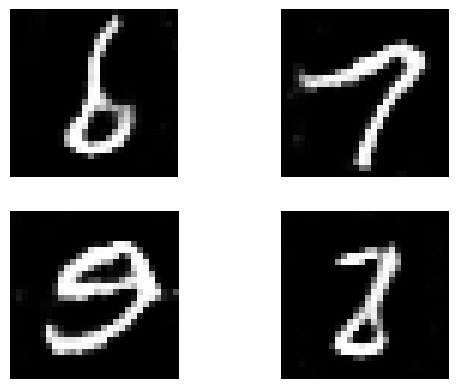

1/1 [==============================] - 0s 20ms/step
Epoch 700, D Loss: 0.6956399977207184, G Loss: 0.722598671913147
1/1 [==============================] - 0s 26ms/step


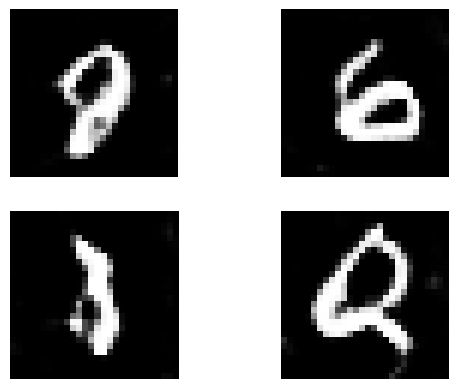

1/1 [==============================] - 0s 17ms/step
Epoch 800, D Loss: 0.6847054362297058, G Loss: 0.6991177797317505
1/1 [==============================] - 0s 22ms/step


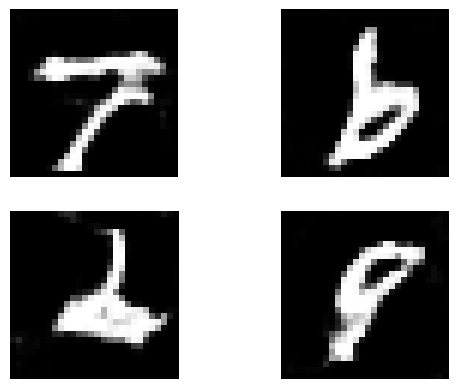

1/1 [==============================] - 0s 22ms/step
Epoch 900, D Loss: 0.7013951539993286, G Loss: 0.6766502857208252
1/1 [==============================] - 0s 19ms/step


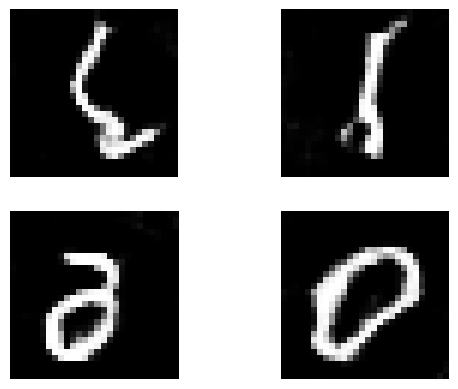

1/1 [==============================] - 0s 21ms/step


In [33]:
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    labels_gan = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, labels_gan)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        samples()

2/2 [==============================] - 0s 6ms/step


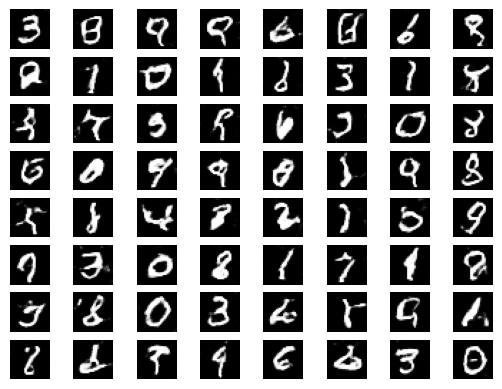

In [34]:

generated_images = generator.predict(np.random.normal(0, 1, (64, latent_dim)))


fig, axs = plt.subplots(8, 8)
count = 0
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        count += 1
plt.show()
